In [1]:
from skimage.transform import warp
from skimage.io import imread
from skimage import measure
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import lsqr

import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import math
import matplotlib

from PIL import Image
from IPython.display import display 

%matplotlib inline

In [2]:
class Mesh():
    def __init__(self, img, mask, quad_size, W):
        self.img = img
        self.mask = mask
        self.quad_size = quad_size
        self.W = W

        width = img.shape[1] - 1
        height = img.shape[0] - 1

        nq_col = math.ceil(width / self.quad_size)
        nq_row = math.ceil(height / self.quad_size)
        self.nq_col = nq_col
        self.nq_row = nq_row

        self.origin_vertices = []
        self.warped_vertices = []
        self.Q = []
        self.Q_label = []
        labels, max_num = measure.label(self.mask, background=1, return_num=True)
        self.labels = labels
        self.max_num = max_num
        print("num of features:", max_num)
        is_mask = []
        group_id = []
        
        for y in self.__arange(height, quad_size):
            for x in self.__arange(width, quad_size):
                self.origin_vertices.append([x, y])
                is_mask.append(mask[y, x] == 0)
                group_id.append(labels[y, x])
       
        self.origin_vertices = np.array(self.origin_vertices).astype(np.float32)
        self.warped_vertices = self.origin_vertices.copy()
        self.warped_vertices = W(self.warped_vertices, 1)
        group_id = np.array(group_id)
        
        # quad
        self.Q_label = []
        idx = np.arange(len(self.origin_vertices)).reshape(self.nq_row+1, self.nq_col+1)
        for r in range(nq_row):
            for c in range(nq_col):
                vidx = [idx[r, c], idx[r, c+1], idx[r+1, c+1], idx[r+1, c]]
                self.Q.append(vidx)
                if any([is_mask[i] for i in vidx]):
                    self.Q_label.append(np.min(list(filter(lambda x: x > 0, [group_id[i] for i in vidx]))))
                else:
                    self.Q_label.append(0)

        self.Q = np.array(self.Q)
        self.Q_label = np.array(self.Q_label)
        
                
        # boundaries as hard constraints
        self.non_constraints_idx = idx[1:-1, :][:, 1:-1].flatten()
        self.idx_is_constraints = np.array([True] * (len(idx.flatten())))
        self.idx_is_constraints[self.non_constraints_idx] = False
        
        self.idx_to_ncidx = {}
        for i, idx in enumerate(self.non_constraints_idx):
            self.idx_to_ncidx[idx] = i
        
    
    def __arange(self, stop, step):
        """ helper function: same as np.arange but appends stop to the end """
        ret = np.arange(start=0, stop=stop, step=step)
        ret = np.append(ret, stop)
        return ret

In [3]:
def init_r(n):
    r = []
    for i in range(n):
        r.append(np.identity(2))
    
    return r

In [4]:
def compute_L(mesh, w_f):
    rows = []
    cols = []
    data = []
    row_counts = 0
    
    for i, quad_idx in enumerate(mesh.Q):
        w = w_f if mesh.Q_label[i] else 1
        
        for j in range(4):
            add_row = False
            k = quad_idx[j]
            k_plus1 = quad_idx[(j+1) % 4]
            
            if not mesh.idx_is_constraints[k]:
                rows.append(row_counts)
                cols.append(mesh.idx_to_ncidx[k])
                data.append(-w)
                add_row = True
            
            if not mesh.idx_is_constraints[k_plus1]:
                rows.append(row_counts)
                cols.append(mesh.idx_to_ncidx[k_plus1])
                data.append(w)
                add_row = True
            
            if add_row:
                row_counts += 1

    L = csc_matrix((data, (rows, cols)), shape=(row_counts, len(mesh.non_constraints_idx)))
    
    return L

In [5]:
def compute_b(mesh, w_f, r, R, V):
    b = []
    r_count = 0
    T = None
    w = 1
    m = 1
    for i, quad_idx in enumerate(mesh.Q):
        if mesh.Q_label[i]:
            T = R
            m = r[r_count]
            w = w_f
            r_count += 1
        else:
            T = mesh.W
            m = 1
            w = 1
            
        for j in range(4):
            k = quad_idx[j]
            k_plus1 = quad_idx[(j+1) % 4]
            
            if mesh.idx_is_constraints[k] and mesh.idx_is_constraints[k_plus1]:
                continue
            
            rhs = w * (T(mesh.origin_vertices[k_plus1], m) - T(mesh.origin_vertices[k], m))

            if mesh.idx_is_constraints[k]:
                rhs += w * V[k]
            
            if mesh.idx_is_constraints[k_plus1]:
                rhs += -w * V[k_plus1]
            
            b.append(rhs)
            
    return np.array(b).astype(np.float32)

In [6]:
def solve_and_update(L, b, mesh):
    ret = mesh.warped_vertices.copy()
    x = lsqr(L, b[:, 0])[0]
    y = lsqr(L, b[:, 1])[0]
    
    for i, idx in enumerate(mesh.non_constraints_idx):
        ret[idx, :] = x[i], y[i]
    
    return ret

In [7]:
def update_r(mesh):
    r = []
    is_feature = (mesh.Q_label != 0)
    labels = mesh.Q_label[is_feature]
    ori_vertices = mesh.origin_vertices[mesh.Q][is_feature]
    war_vertices = mesh.warped_vertices[mesh.Q][is_feature]
    lamb_sum = np.array([0.0] * (mesh.max_num))
    lamb_count = np.array([0] * (mesh.max_num))
    
    for warped_ver, origin_ver, label in zip(war_vertices, ori_vertices, labels):
        v = np.mean(origin_ver, axis=0)
        v_prime = np.mean(warped_ver, axis=0)
        
        u = (origin_ver - v).transpose()
        u_prime = (warped_ver - v_prime).transpose()
        
        U, S, Vh = np.linalg.svd(u_prime @ np.linalg.pinv(u))
        lamb_sum[label - 1] += np.min(S)
        lamb_count[label - 1] += 1
        r.append((Vh.T) @ (U.T))
    
    lamb_avg = lamb_sum / lamb_count
    for i, label in enumerate(labels):
        r[i] *= lamb_avg[label - 1]
    
    return r

In [8]:
def imclone(img):
    canvas = img.copy()
    canvas.fill(0)
    return canvas

def warping(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img.shape[::-1][1:])
    canvas = imclone(img)
    cv2.fillConvexPoly(canvas, np.array([dst]).astype(np.int32), [255, 255, 255])
    cv2.bitwise_and(warped, canvas, canvas)
    return canvas

def quad_to_img(img, mesh, V):
    canvas = imclone(img)

    for quad in mesh.Q:
        src = np.array(mesh.warped_vertices[quad]).astype(np.float32)
        dst = np.array(V[quad]).astype(np.float32)
        piece_img = warping(img, src, dst)
        cv2.bitwise_or(piece_img, canvas, canvas)
    
    return canvas

In [9]:
def plot_mesh(mesh, V):
    tmp = V.reshape(mesh.nq_row+1, (mesh.nq_col+1), 2)
    plt.figure(figsize=(6,6))
    plt.gca().set_aspect('equal', adjustable='box')
    
    for r in range(mesh.nq_row+1):
        plt.plot(tmp[r][:, 0], tmp[r][:, 1], c='gray')
    for c in range(mesh.nq_col+1):
        plt.plot(tmp[:, c][:, 0], tmp[:, c][:, 1], c='gray')

    plt.gca().invert_yaxis()
    plt.show()

In [10]:
# parameters
select = 2
input_img_path = ["./planet.jpg", "./planet_mask_3.jpeg", "./planet_real.jpg"]
# input_img_path = ["./shell.jpg", "./shell_mask.jpg", "./shell_real.jpg"]
# input_img_path = ["./lion.jpg", "./lion_mask.png", "./shell_real.jpg"]
# input_img_path = ["./cat-img.jpg", "cat-img-mask.jpg", "./shell_real.jpg"]

height_multiplier = 2
width_multiplier = 1
matrix = None

w_f = 10
quad_size = 5
iteration = 5

# read files
original_img = imread(input_img_path[0])
mask = imread(input_img_path[1], as_gray=True)
mask[mask >= 0.5] = 1
mask[mask < 0.5] = 0
mask_img = mask.astype(np.int32)

In [11]:
def widening(img):
    height = int(img.shape[0] * height_multiplier)
    width = int(img.shape[1] * width_multiplier)
    res = cv2.resize(img,(width, height), interpolation = cv2.INTER_CUBIC)
    
    return res

# def wave(xy):
#     xy[:, 1] += 20*np.sin(2*np.pi*xy[:, 0]/256)
#     return xy

def Wider(xy, w):
    xy = xy.copy()
    if xy.shape == (2,):
        xy[1] *= height_multiplier
        xy[0] *= width_multiplier
    else:
        xy[:, 1] *= height_multiplier
        xy[:, 0] *= width_multiplier
    return xy

def sine_wave(xy, w):
    xy = xy.copy()
    if xy.shape == (2,):
        xy[1] += 20 * np.sin(2*np.pi*xy[0]/256)
    else:
        xy[:, 1] += 20*np.sin(2*np.pi*xy[:, 0]/256)
    
    return w * xy

def Parallelogram(xy, w):
    xy = xy.copy()
    return xy @ matrix

def R(xy, w):
    return w @ xy

In [12]:
if select == 1:    
    W = Wider
    warped_img = widening(original_img)
elif select == 2:
    W = sine_wave
elif select == 3:
    W = Parallelogram
    M = np.array([[1.0, 1.0, 0.0], [0.0, 2.0, 0.0]])
    matrix = M[:, :2].T
    width, height = (M[:, :2] @ [original_img.shape[1], original_img.shape[0]]).astype(np.int32)
    warped_img = cv2.warpAffine(original_img, M, (width, height))

num of features: 12
preprocessing time:  0.07332992553710938 s
numbers of variable to solve: 7192
time:  0.8461649417877197 s


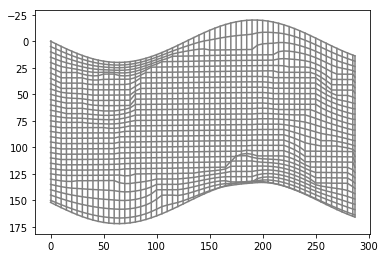

0
time:  0.9372179508209229 s
time:  1.2359578609466553 s
time:  1.0085382461547852 s
time:  1.1408298015594482 s


In [13]:
# update points
start = time.time()
mesh = Mesh(original_img, mask, quad_size, W)

r = init_r(np.sum(mesh.Q_label != 0))
L = compute_L(mesh, w_f)
V = mesh.warped_vertices.copy()
end = time.time()
print("preprocessing time: ", end - start, "s")
print("numbers of variable to solve:", len(mesh.Q) * 4)
for step in range(iteration):
    start = time.time()
    b = compute_b(mesh, w_f, r, R, V)
    V = solve_and_update(L, b, mesh)
    r = update_r(mesh)
    end = time.time()
    print("time: ", end - start, "s")
    if step % 10 == 0:
        plot_mesh(mesh, V)
        print(step)

In [14]:
if select == 2:
    def warped_canvas(img, mesh, V):
        canvas = imclone(img)

        for quad in mesh.Q:
            src = np.array(mesh.origin_vertices[quad]).astype(np.float32)
            dst = np.array(V[quad]).astype(np.float32)
            piece_img = warping(img, src, dst)
            cv2.bitwise_or(piece_img, canvas, canvas)
        return canvas
    
    def warped_canvas_2(img, mesh, V):
        canvas = imclone(img)

        for quad in mesh.Q:
            src = np.array(mesh.origin_vertices[quad]).astype(np.float32)
            dst = np.array(mesh.warped_vertices[quad]).astype(np.float32)
            piece_img = warping(img, src, dst)
            cv2.bitwise_or(piece_img, canvas, canvas)
        return canvas
    
    warped_img = warped_canvas_2(original_img, mesh, V)
    canvas = warped_canvas(original_img, mesh, V)
else:
    canvas = quad_to_img(warped_img, mesh, V).astype(np.int32)

<Figure size 432x288 with 0 Axes>

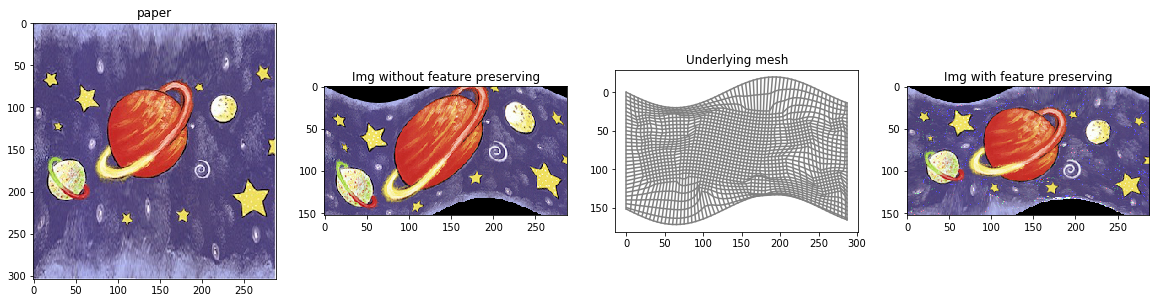

In [15]:
real_img = imread(input_img_path[2])
plt.tight_layout()

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
ax[0].imshow(real_img)
ax[0].set_aspect('equal')
ax[0].title.set_text("paper")

ax[1].imshow(warped_img.astype(np.int32))
ax[1].set_aspect('equal')
ax[1].title.set_text("Img without feature preserving")

tmp = V.reshape(mesh.nq_row+1, (mesh.nq_col+1), 2)
for r in range(mesh.nq_row+1):
    ax[2].plot(tmp[r][:, 0], tmp[r][:, 1], c='gray')
for c in range(mesh.nq_col+1):
    ax[2].plot(tmp[:, c][:, 0], tmp[:, c][:, 1], c='gray')

ax[2].invert_yaxis()
ax[2].set_aspect('equal')
ax[2].title.set_text("Underlying mesh")

ax[3].imshow(canvas)
ax[3].set_aspect('equal')
ax[3].title.set_text("Img with feature preserving")

# plt.savefig("cat_parallelogram_result.png", bbox_inches='tight')
plt.show()